In [69]:
import torch
import h5py
import numpy as np
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pickle
from sklearn.preprocessing import normalize
from scipy.sparse import lil_matrix, csr_matrix, hstack
from tqdm import tqdm
import math

In [70]:
# 변수 선언 block
train_rec_file_list = ["./train_recs/CF_rec_clf_dim_64.pickle",
                "./train_recs/Graph_rec_clf_1_8_depth_3.pickle",
                "./train_recs/Graph_rec_clf_1_8_depth_1.pickle",]

valid_rec_file_list = ["./valid_recs/CF_rec_clf_dim_64.pickle",
                "./valid_recs/Graph_rec_clf_1_8_depth_3.pickle",
                "./valid_recs/Graph_rec_clf_1_8_depth_1.pickle",]

train_path = './Container/train'

valid_path = './Container/valid_clf'

state_dict_save_path = "./ensemble_model/ensemble_model_best_clf.pt"

loss_fig_path = "./ensemble_model/ensemble_clf_loss.png"
acc_fig_path = "./ensemble_model/ensemble_clf_acc.png"

epochs = 10

In [71]:
class RecDataset(Dataset):
    def __init__(self, recs_list, answer_dict, query_num, item_num, transform=None, target_transform=None):
        # rec_matrix = [query num, model_num, item_num]
        self.rec_matrix = []
        for i in range(query_num):
            self.rec_matrix.append(lil_matrix((len(rec_file_list), item_num)))
        for i, recs in enumerate(recs_list):
            for query in tqdm(recs.keys()):
                rec = recs[query]
                rec_items, rec_scores = [rec_ for rec_, score in rec], [score for rec_, score in rec]
                rec_scores = normalize(np.array(rec_scores)[:,np.newaxis], axis=0).ravel()
                for item, score in zip(rec_items, rec_scores):
                    self.rec_matrix[query][i, item] = score
        self.labels = answer_dict
        self.transform = transform
        self.target_transform = target_transform
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    def __len__(self):
        return len(self.rec_matrix)

    def __getitem__(self, idx):
        rec_matrix = self.rec_matrix[idx].toarray()
        label = self.labels[idx]
        if self.transform:
            rec_matrix = self.transform(rec_matrix).to(self.device)
        if self.target_transform:
            label = self.target_transform(label)
        return rec_matrix.to(self.device), label.to(self.device)

In [72]:
class Network(nn.Module):
    def __init__(self, model_len, k=10):
        super(Network, self).__init__()
        self.w1 = torch.nn.Parameter(torch.rand(k, model_len))
        self.w2 = torch.nn.Parameter(torch.rand(1, k))
        
    def forward(self, x):
        #import ipdb; ipdb.set_trace()
        x = x.float()
        x = torch.einsum('nm, bmp -> bnp', self.w1, x)
        x = torch.einsum('nm, bmp -> bnp', self.w2, x).squeeze(1)
        return x

In [73]:
recs_list = []
for rec_file in train_rec_file_list:
    with open(rec_file, 'rb') as f:
        recs = pickle.load(f)
        recs_list.append(recs)

query_num = len(recs_list[0])
item_num = 20

h5f_train = h5py.File(train_path, 'r')
answer = h5f_train['labels_int_enc'][:].astype(np.int64)
h5f_train.close()

answer_dict = {}
for i, ans in enumerate(answer):
    answer_dict[i] = ans

train_data = RecDataset(recs_list, answer_dict, query_num, item_num, transform=torch.Tensor, target_transform=torch.tensor)
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
###############

recs_list = []
for rec_file in valid_rec_file_list:
    with open(rec_file, 'rb') as f:
        recs = pickle.load(f)
        recs_list.append(recs)

query_num = len(recs_list[0])
item_num = 20

h5f_valid = h5py.File(valid_path, 'r')
answer = h5f_valid['labels_int_enc'][:].astype(np.int64)
h5f_valid.close()

answer_dict = {}
for i, ans in enumerate(answer):
    answer_dict[i] = ans

test_data = RecDataset(recs_list, answer_dict, query_num, item_num, transform=torch.Tensor, target_transform=torch.tensor)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████| 7848/7848 [00:00<00:00, 14426.45it/s]


In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Network(len(rec_file_list), k=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_loss = 0
    for batch, (X, y) in tqdm(enumerate(dataloader),total=len(dataloader)):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / (batch + 1)
    print(f"Train loss: {avg_loss:>7f}")
    return avg_loss
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

train_loss_lst = []
test_loss_lst = []
test_acc_lst = []
min_test_loss = math.inf
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
    train_loss_lst.append(train_loss)
    test_loss_lst.append(test_loss)
    test_acc_lst.append(test_acc)
    print(model.parameters())
    if test_loss < min_test_loss:
        min_test_loss = test_loss
        torch.save(model.state_dict(), state_dict_save_path)
print("Done!")

Epoch 1
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:04<00:00, 90.13it/s]


Train loss: 1.222378


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 95.87it/s]


Test Error: 
 Accuracy: 67.4%, Avg loss: 1.140482 

<generator object Module.parameters at 0x00000274D43E7890>
Epoch 2
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:04<00:00, 90.22it/s]


Train loss: 0.979095


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 96.62it/s]


Test Error: 
 Accuracy: 69.7%, Avg loss: 1.093755 

<generator object Module.parameters at 0x00000274D43EACF0>
Epoch 3
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:04<00:00, 91.02it/s]


Train loss: 0.952677


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 98.71it/s]


Test Error: 
 Accuracy: 70.1%, Avg loss: 1.090782 

<generator object Module.parameters at 0x00000274D43EA660>
Epoch 4
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:04<00:00, 91.09it/s]


Train loss: 0.945631


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 94.54it/s]


Test Error: 
 Accuracy: 70.0%, Avg loss: 1.094980 

<generator object Module.parameters at 0x00000274D43E7890>
Epoch 5
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 368/368 [00:03<00:00, 115.11it/s]


Train loss: 0.943480


100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 113.15it/s]


Test Error: 
 Accuracy: 69.9%, Avg loss: 1.094202 

<generator object Module.parameters at 0x00000274D43EA660>
Epoch 6
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 368/368 [00:03<00:00, 100.41it/s]


Train loss: 0.942987


100%|████████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 92.83it/s]


Test Error: 
 Accuracy: 69.8%, Avg loss: 1.093679 

<generator object Module.parameters at 0x00000274D43E7AC0>
Epoch 7
-------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 368/368 [00:03<00:00, 98.96it/s]


Train loss: 0.942819


100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 101.07it/s]


Test Error: 
 Accuracy: 69.9%, Avg loss: 1.095704 

<generator object Module.parameters at 0x00000274D43EA740>
Epoch 8
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 368/368 [00:03<00:00, 108.42it/s]


Train loss: 0.942849


100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 120.94it/s]


Test Error: 
 Accuracy: 69.9%, Avg loss: 1.095691 

<generator object Module.parameters at 0x00000274D43E7AC0>
Epoch 9
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 368/368 [00:03<00:00, 118.07it/s]


Train loss: 0.942591


100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:01<00:00, 120.23it/s]


Test Error: 
 Accuracy: 69.8%, Avg loss: 1.094275 

<generator object Module.parameters at 0x00000274D43E7510>
Epoch 10
-------------------------------


100%|███████████████████████████████████████████████████████████████████████████████| 368/368 [00:03<00:00, 118.29it/s]


Train loss: 0.942908


100%|███████████████████████████████████████████████████████████████████████████████| 123/123 [00:00<00:00, 124.37it/s]

Test Error: 
 Accuracy: 69.9%, Avg loss: 1.099040 

<generator object Module.parameters at 0x00000274D43EACF0>
Done!


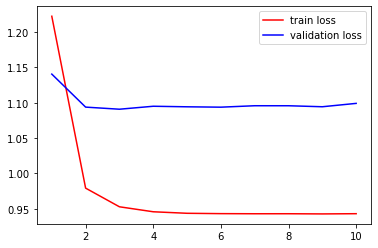

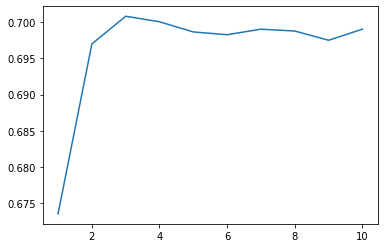

In [75]:
import matplotlib.pyplot as plt
epoch_lst = list(range(1, epochs+1))
plt.plot(epoch_lst, train_loss_lst, 'r', label='train loss')
plt.plot(epoch_lst, test_loss_lst, 'b', label = 'validation loss')
plt.legend()
plt.savefig(loss_fig_path)
plt.show()

plt.plot(epoch_lst, test_acc_lst)
plt.savefig(acc_fig_path)
plt.show()